## Data Preparation and Cleaning
The data in "SPLK.csv" came from https://finance.yahoo.com/quote/splk/history/, it contains five years data start from July 2012.

In [1]:
import pandas
splunk = pandas.read_csv("SPLK.csv")

print splunk.head()

         Date       Open       High        Low      Close  Adj Close  Volume
0  2012-07-31  28.650000  29.549999  28.639999  29.400000  29.400000  518400
1  2012-08-01  29.690001  29.799999  28.680000  28.950001  28.950001  338300
2  2012-08-02  28.400000  28.540001  27.000000  28.280001  28.280001  840100
3  2012-08-03  28.900000  28.990000  27.530001  27.940001  27.940001  422100
4  2012-08-06  27.980000  29.740000  27.879999  29.160000  29.160000  624100


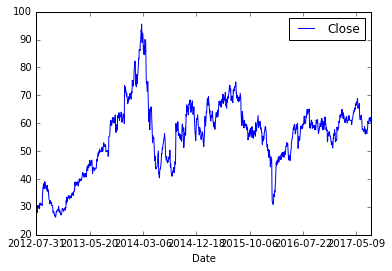

In [2]:
%matplotlib inline
splunk.plot.line(x="Date",y="Close")

In [3]:
print splunk.describe()

              Open         High          Low        Close    Adj Close  \
count  1257.000000  1257.000000  1257.000000  1257.000000  1257.000000   
mean     55.072053    56.027661    54.031679    55.050048    55.050048   
std      12.895890    13.067184    12.602759    12.797729    12.797729   
min      26.309999    26.700001    26.100000    26.299999    26.299999   
25%      47.099998    48.020000    46.220001    47.139999    47.139999   
50%      57.430000    58.439999    56.349998    57.500000    57.500000   
75%      62.360001    63.340000    61.459999    62.480000    62.480000   
max     102.940002   106.150002    93.739998    95.500000    95.500000   

                Volume  
count      1257.000000  
mean    1871072.712808  
std     1583970.347551  
min      154800.000000  
25%     1066700.000000  
50%     1484800.000000  
75%     2116700.000000  
max    20229600.000000  


Shift is often used for time serials data anaylsis

In [4]:
splunk_tomorrow = splunk.shift()
print splunk_tomorrow.head()

         Date       Open       High        Low      Close  Adj Close  Volume
0         NaN        NaN        NaN        NaN        NaN        NaN     NaN
1  2012-07-31  28.650000  29.549999  28.639999  29.400000  29.400000  518400
2  2012-08-01  29.690001  29.799999  28.680000  28.950001  28.950001  338300
3  2012-08-02  28.400000  28.540001  27.000000  28.280001  28.280001  840100
4  2012-08-03  28.900000  28.990000  27.530001  27.940001  27.940001  422100


data cleaning, using dropna() can remove all empty data

In [5]:
splunk_diff = pandas.DataFrame({"Date":splunk_tomorrow["Date"],"Value":splunk_tomorrow["Close"] - splunk["Close"]})
#splunk_diff = splunk_diff[1:]
splunk_diff = splunk_diff.dropna()
print splunk_diff.head()

         Date     Value
1  2012-07-31  0.449999
2  2012-08-01  0.670000
3  2012-08-02  0.340000
4  2012-08-03 -1.219999
5  2012-08-06 -1.350000


## BINARY ENCODING APPROACH

Discretization involves converting continuous variables into discrete variables. The most popular discretization approach is binning. Binning involves classifying the output from continuous variables into a mutually exclusive set of "bins" each of which represent a possible interval within which the random variable may fall.

Since we don't know the range of market returns (our continuous variable), we simply bin them into positive returns and negative returns which are represented as a 1 and 0 bit respectively. To avoid bias we add a special case for returns equal to exactly 0.0%, these returns are represented at as both 0 and 1 i.e. 01 bit strings:

bi=f(ri)=⎧⎩⎨⎪⎪1,0,01,if ri>0.0if ri<0.0if ri=0.0bi=f(ri)={1,if ri>0.00,if ri<0.001,if ri=0.0

where bibi represents the bit in the bit string at index ii and riri represents the return generated by the security being discretized at time ii. If the security goes up as often as it goes down, then the number of zeros and ones in the resulting bit string should be uniformly distributed. This is discussed in more detail in the next section.

Two additional conversion methods were implemented and tested which involved converting basis points and floating point returns into binary respectively. The problem with these is that they introduce biases which result in even strong cryptographic random number generators failing numerous tests in the suite.

In [6]:
def check(x):
    if x.Value > 0:
        return "1"
    elif x.Value < 0:
        return "0"
    else:
        return "01"

bin_encoding = ""
for item in splunk_diff.apply(check, axis=1).iteritems():
    bin_encoding = bin_encoding + item[1]

print bin_encoding

1110010111100011010111000001100011010101011101111101011101011110110110110001000101001100111100000101111000011000101000100011001001000101111001010110001100111010010011100100001011100101011000011010100001110010111000110100110100010000100101101100001100000110101111010001110000000001110000110011011011100110010010110011001110000010110101111101111010011001011101101101000000111010110000001010100001011001111011001011101100111100110000101111010111111011100000001010110001000010010000000111111001010100011001101111010010011010110010001001101111010101010001011100001010010100111001001010100010111000111111100010101111110011011010001110100000110001000110011110111001100111110011100000111001000001101001000100011000110011101011011000000110110101110010100010011010011011010000111111001111010101101110101110000110101110001101110100001011100000011010101101010110011010000001111110101110011110010011011100010010000010001010110101010101001101011010110000110110111100111000000000000010011100001001011001010000010010

## TEST 01 - FREQUENCY (MONOBIT)

This test looks at the proportion of 0 bits to 1 bits in a given binary sequence. Assuming the sequence is uniformly distributed this proportion should be close to 1 meaning that the number of 1 bits was approximately equal to the number of 0 bits. In this context, because a 0 bit represents a down day and a 1 bit represents an up day, this test checks whether down and up days on the market are uniformly distributed over time i.e. equally probable.

A failure of the monobit test may indicate something about the relative profitability of simple buy and hold strategies because, if the market is more likely to go up than down, then simply buying and holding the market is likely to be a profitable trading strategy. This assumes, however, that the average size of an up-day in percentage terms is greater than or equal to the average size of a down-day in percentage terms.

In [7]:
import math
import scipy.special as spc
def monobit(bin_data):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
  
    The focus of this test is the proportion of zeros and ones for the entire sequence. The purpose of this test is
    to determine whether the number of ones and zeros in a sequence are approximately the same as would be expected
    for a truly random sequence. This test assesses the closeness of the fraction of ones to 1/2, that is the number
    of ones and zeros ina  sequence should be about the same. All subsequent tests depend on this test.
  
    :param bin_data: a binary string
    :return: the p-value from the test
    """
    count = 0
    # If the char is 0 minus 1, else add 1
    for char in bin_data:
        if char == '0':
            count -= 1
        else:
            count += 1
    # Calculate the p value
    sobs = count / math.sqrt(len(bin_data))
    p_val = spc.erfc(math.fabs(sobs) / math.sqrt(2))
    return p_val

# http://blog.minitab.com/blog/understanding-statistics/what-can-you-say-when-your-p-value-is-greater-than-005
print monobit(bin_encoding)

0.215138341156


In [9]:
count = {"1":0,"0":0}
for c in bin_encoding:
    if c == "1" :
        count["1"] +=  1
    else:
        count["0"] += 1

print count 

{'1': 608, '0': 652}


## TEST 02 - BLOCK FREQUENCY TEST

This test is a generalization of the Monobit test which looks the proportion of 0 bits to 1 bits in NN blocks of size MM extracted from a given binary sequence. Assuming uniform randomness the number of 0 bits and 1 bits should be approximately M2M2 per block i.e. each block is filled with, on average, as many 1 bits and 0 bits. In our context this test looks at the probability of up and down days occurring over finite "windows" or periods of time. 

In [10]:
def block_frequency(bin_data, block_size=64):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this tests is the proportion of ones within M-bit blocks. The purpose of this tests is to determine
    whether the frequency of ones in an M-bit block is approximately M/2, as would be expected under an assumption
    of randomness. For block size M=1, this test degenerates to the monobit frequency test.
    :param bin_data: a binary string
    :return: the p-value from the test
    :param block_size: the size of the blocks that the binary sequence is partitioned into
    """
    # Work out the number of blocks, discard the remainder
    num_blocks = int(math.floor(len(bin_data) / block_size))
    block_start, block_end = 0, block_size
    # Keep track of the proportion of ones per block
    proportion_sum = 0.0
    for i in range(num_blocks):
        # Slice the binary string into a block
        block_data = bin_data[block_start:block_end]
        # Keep track of the number of ones
        ones_count = 0
        for char in block_data:
            if char == '1':
                ones_count += 1
        pi = ones_count / block_size
        proportion_sum += pow(pi - 0.5, 2.0)
        # Update the slice locations
        block_start += block_size
        block_end += block_size
    # Calculate the p-value
    chi_squared = 4.0 * block_size * proportion_sum
    p_val = spc.gammaincc(num_blocks / 2, chi_squared / 2)
    return p_val
print block_frequency(bin_encoding)

4.17259106753e-247


## TEST 03 - RUNS TEST

Arguably the most well known test for randomness, the runs test focusses on the number of runs which appear in a binary sequence. A run is defined as an uninterrupted sequence of identical bits. A run of length kk is an uninterrupted sequence of kk identical bits. The runs test checks whether the number of runs in the sequence is significantly different from what is expected from a sequence under the assumption of uniform randomness. The number of runs also indicates the frequency with which the sequence oscillates between 0 and 1 bits.

In this context, a run is a sequence of consecutive trading days wherein the market was up or down. As such, performance on this test may imply something about either the momentum or mean reversion anomalies. Previous academic studies have shown that the market has more runs than expected and therefore the market is said to oscillate more quickly between "up runs" and "down runs" than would be expected from a random sequence. 

In [11]:
def independent_runs(bin_data):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this tests if the total number of runs in the sequences, where a run is an uninterrupted sequence
    of identical bits. A run of length k consists of k identical bits and is bounded before and after with a bit of
    the opposite value. The purpose of the runs tests is to determine whether the number of runs of ones and zeros
    of various lengths is as expected for a random sequence. In particular, this tests determines whether the
    oscillation between zeros and ones is either too fast or too slow.
    :param bin_data: a binary string
    :return: the p-value from the test
    """
    ones_count, n = 0, len(bin_data)
    for char in bin_data:
        if char == '1':
            ones_count += 1
    p, vobs = float(ones_count) / n, 1
    tau = 2 / math.sqrt(len(bin_data))
    if abs(p - 0.5) > tau:
        return 0.0
    else:
        for i in range(1, n):
            if bin_data[i] != bin_data[i - 1]:
                vobs += 1
        # expected_runs = 1 + 2 * (n - 1) * 0.5 * 0.5
        # print("\t", Colours.Italics + "Observed runs =", vobs, "Expected runs", expected_runs, Colours.End)
        num = abs(vobs - 2.0 * n * p * (1.0 - p))
        den = 2.0 * math.sqrt(2.0 * n) * p * (1.0 - p)
        p_val = spc.erfc(float(num / den))
        return p_val

print independent_runs(bin_encoding)

0.506769961267


## TEST 04 - LONGEST RUNS (IN A BLOCK) TEST

As mentioned in the independent runs test (test 03) a run is any uninterrupted sequence of identical bits. The previous tests looks at the number of runs and checks whether this is statistically significantly different from the expected number of runs from a true random binary sequence. The longest run (of ones in a block) test checks whether the longest run of 1 bits in M-bit blocks is statistically significantly longer (or shorter) than what would be expected from a true random binary sequence. Since a significant difference in the length of the longest run of 1's implies a significant difference in the length of the longest run of 0's only one test is run. 

In this context, this test measures whether or not the number of subsequent up-days in a certain window of time is consistent with what would be produced if market returns were random and generated by a coin flip. A failure of this test may indicate the presence of either momentum or strong mean reversion. Momentum is a property of financial markets which makes the probability of the market having an up day (or down day), given a previous run of up days (or down days) higher. Mean reversion is the opposite - it is a property of financial markets which makes the probability of the market having an up day (or down day), given a previous run of up days (or down days) lower.

In [12]:
import numpy
def longest_runs(bin_data):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of the tests is the longest run of ones within M-bit blocks. The purpose of this tests is to determine
    whether the length of the longest run of ones within the tested sequences is consistent with the length of the
    longest run of ones that would be expected in a random sequence. Note that an irregularity in the expected
    length of the longest run of ones implies that there is also an irregularity ub tge expected length of the long
    est run of zeroes. Therefore, only one test is necessary for this statistical tests of randomness
    :param bin_data: a binary string
    :return: the p-value from the test
    """
    if len(bin_data) < 128:
        print("\t", "Not enough data to run test!")
        return -1.0
    elif len(bin_data) < 6272:
        k, m = 3, 8
        v_values = [1, 2, 3, 4]
        pik_values = [0.21484375, 0.3671875, 0.23046875, 0.1875]
    elif len(bin_data) < 75000:
        k, m = 5, 128
        v_values = [4, 5, 6, 7, 8, 9]
        pik_values = [0.1174035788, 0.242955959, 0.249363483, 0.17517706, 0.102701071, 0.112398847]
    else:
        k, m = 6, 10000
        v_values = [10, 11, 12, 13, 14, 15, 16]
        pik_values = [0.0882, 0.2092, 0.2483, 0.1933, 0.1208, 0.0675, 0.0727]

    # Work out the number of blocks, discard the remainder
    # pik = [0.2148, 0.3672, 0.2305, 0.1875]
    num_blocks = int(math.floor(len(bin_data) / m))
    frequencies = numpy.zeros(k + 1)
    block_start, block_end = 0, m
    for i in range(num_blocks):
        # Slice the binary string into a block
        block_data = bin_data[block_start:block_end]
        # Keep track of the number of ones
        max_run_count, run_count = 0, 0
        for j in range(0, m):
            if block_data[j] == '1':
                run_count += 1
                max_run_count = max(max_run_count, run_count)
            else:
                max_run_count = max(max_run_count, run_count)
                run_count = 0
        max_run_count = max(max_run_count, run_count)
        if max_run_count < v_values[0]:
            frequencies[0] += 1
        for j in range(k):
            if max_run_count == v_values[j]:
                frequencies[j] += 1
        if max_run_count > v_values[k - 1]:
            frequencies[k] += 1
        block_start += m
        block_end += m
    # print(frequencies)
    chi_squared = 0
    for i in range(len(frequencies)):
        chi_squared += (pow(frequencies[i] - (num_blocks * pik_values[i]), 2.0)) / (num_blocks * pik_values[i])
    p_val = spc.gammaincc(float(k / 2), float(chi_squared / 2))
    return p_val

print longest_runs(bin_encoding)

0.0209420436887


## TEST 05 - BINARY MATRIX RANK TEST
The Binary Matrix Rank test is quite interesting because it takes the binary sequence and transforms it into a sequence of matrices. The test then works by testing the linear dependence between those matrices. A set of vectors is said to be linearly dependent if one or more of the vectors in the set can be defined as a linear combination of the other vectors. This is related to the concept of dimension, in that if a linearly dependent matrix were added to the set it would not result in any increased dimensionality because it would fall within the span of the previous matrices. For more information on this concept check out the Khan Academy videos.

Relating the concept of linear dependence back to the financial markets context is quite difficult, but let me give it a shot anyway. Each matrix represents a window of q×qq×q days wherein the first row of each matrix represents qq days. If the first matrix, M1M1, were linearly dependent on the next matrix, M2M2, then we would be saying that the returns in the second window can be expressed as a function of the returns in the first window meaning that whether the markets went up or down in M1M1 would determine whether or not they went up or down in M2M2. Again this can either relate back to mean-reversion or momentum albeit in a more challenging way.


In [16]:
import copy

class BinaryMatrix:
    def __init__(self, matrix, rows, cols):
        """
        This class contains the algorithm specified in the NIST suite for computing the **binary rank** of a matrix.
        :param matrix: the matrix we want to compute the rank for
        :param rows: the number of rows
        :param cols: the number of columns
        :return: a BinaryMatrix object
        """
        self.num_rows = rows
        self.num_cols = cols
        self.matrix = matrix
        self.m = min(rows, cols)

    def compute_rank(self, verbose=False):
        """
        This method computes the binary rank of self.matrix
        :param verbose: if this is true it prints out the matrix after the forward elimination and backward elimination
        operations on the rows. This was used to testing the method to check it is working as expected.
        :return: the rank of the matrix.
        """
        if verbose:
            print("Original Matrix\n", self.matrix)

        i = 0
        while i < self.m - 1:
            if self.matrix[i][i] == 1:
                self.perform_row_operations(i, True)
            else:
                found = self.find_unit_element_swap(i, True)
                if found == 1:
                    self.perform_row_operations(i, True)
            i += 1

        if verbose:
            print("Intermediate Matrix\n", self.matrix)

        i = self.m - 1
        while i > 0:
            if self.matrix[i][i] == 1:
                self.perform_row_operations(i, False)
            else:
                if self.find_unit_element_swap(i, False) == 1:
                    self.perform_row_operations(i, False)
            i -= 1

        if verbose:
            print("Final Matrix\n", self.matrix)

        return self.determine_rank()

    def perform_row_operations(self, i, forward_elimination):
        """
        This method performs the elementary row operations. This involves xor'ing up to two rows together depending on
        whether or not certain elements in the matrix contain 1's if the "current" element does not.
        :param i: the current index we are are looking at
        :param forward_elimination: True or False.
        """
        if forward_elimination:
            j = i + 1
            while j < self.num_rows:
                if self.matrix[j][i] == 1:
                    self.matrix[j, :] = (self.matrix[j, :] + self.matrix[i, :]) % 2
                j += 1
        else:
            j = i - 1
            while j >= 0:
                if self.matrix[j][i] == 1:
                    self.matrix[j, :] = (self.matrix[j, :] + self.matrix[i, :]) % 2
                j -= 1

    def find_unit_element_swap(self, i, forward_elimination):
        """
        This given an index which does not contain a 1 this searches through the rows below the index to see which rows
        contain 1's, if they do then they swapped. This is done on the forward and backward elimination
        :param i: the current index we are looking at
        :param forward_elimination: True or False.
        """
        row_op = 0
        if forward_elimination:
            index = i + 1
            while index < self.num_rows and self.matrix[index][i] == 0:
                index += 1
            if index < self.num_rows:
                row_op = self.swap_rows(i, index)
        else:
            index = i - 1
            while index >= 0 and self.matrix[index][i] == 0:
                index -= 1
            if index >= 0:
                row_op = self.swap_rows(i, index)
        return row_op

    def swap_rows(self, row_one, row_two):
        """
        This method just swaps two rows in a matrix. Had to use the copy package to ensure no memory leakage
        :param row_one: the first row we want to swap and
        :param row_two: the row we want to swap it with
        :return: 1
        """
        temp = copy.copy(self.matrix[row_one, :])
        self.matrix[row_one, :] = self.matrix[row_two, :]
        self.matrix[row_two, :] = temp
        return 1

    def determine_rank(self):
        """
        This method determines the rank of the transformed matrix
        :return: the rank of the transformed matrix
        """
        rank = self.m
        i = 0
        while i < self.num_rows:
            all_zeros = 1
            for j in range(self.num_cols):
                if self.matrix[i][j] == 1:
                    all_zeros = 0
            if all_zeros == 1:
                rank -= 1
            i += 1
        return rank

def matrix_rank(bin_data, q=32):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of the test is the rank of disjoint sub-matrices of the entire sequence. The purpose of this test is
    to check for linear dependence among fixed length sub strings of the original sequence. Note that this test
    also appears in the DIEHARD battery of tests.
    :param bin_data: a binary string
    :return: the p-value from the test
    """
    shape = (q, q)
    n = len(bin_data)
    block_size = int(q * q)
    num_m = int(math.floor(n / (q * q)))
    block_start, block_end = 0, block_size
    # print(q, n, num_m, block_size)

    if num_m > 0:
        max_ranks = [0, 0, 0]
        for im in range(num_m):
            block_data = bin_data[block_start:block_end]
            block = numpy.zeros(len(block_data))
            for i in range(len(block_data)):
                if block_data[i] == '1':
                    block[i] = 1.0
            m = block.reshape(shape)
            ranker = BinaryMatrix(m, q, q)
            rank = ranker.compute_rank()
            # print(rank)
            if rank == q:
                max_ranks[0] += 1
            elif rank == (q - 1):
                max_ranks[1] += 1
            else:
                max_ranks[2] += 1
            # Update index trackers
            block_start += block_size
            block_end += block_size

        piks = [1.0, 0.0, 0.0]
        for x in range(1, 50):
            piks[0] *= 1 - (1.0 / (2 ** x))
        piks[1] = 2 * piks[0]
        piks[2] = 1 - piks[0] - piks[1]

        chi = 0.0
        for i in range(len(piks)):
            chi += pow((max_ranks[i] - piks[i] * num_m), 2.0) / (piks[i] * num_m)
        p_val = math.exp(-chi / 2)
        return p_val
    else:
        return -1.0

print matrix_rank(bin_encoding)   

0.693720140989


## TEST 06 - DISCRETE FOURIER TRANSFORM TEST

The Discrete Fourier Transform test, more widely known as the Spectral test, is one of the best known tests for random number generators. The test was developed by Donald Knuth and was used to identify some of the biggest shortcomings of the popular linear congruential family of pseudo random number generators. This test works by transforming the binary sequence from the time dimension to the frequency dimension using the discrete Fourier transform. Once this has been done the test looks for periodic features (patterns which are near to each other) whose presence would indicate a deviation from true randomness. The image below shows how this test can be used to expose the shortcomings of the aforementioned linear congruential generator family:

In [19]:
import scipy.fftpack as sff

def spectral(bin_data):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the peak heights in the Discrete Fourier Transform of the sequence. The purpose of
    this test is to detect periodic features (i.e., repetitive patterns that are near each other) in the tested
    sequence that would indicate a deviation from the assumption of randomness. The intention is to detect whether
    the number of peaks exceeding the 95 % threshold is significantly different than 5 %.
    :param bin_data: a binary string
    :return: the p-value from the test
    """
    n = len(bin_data)
    plus_minus_one = []
    for char in bin_data:
        if char == '0':
            plus_minus_one.append(-1)
        elif char == '1':
            plus_minus_one.append(1)
    # Product discrete fourier transform of plus minus one
    s = sff.fft(plus_minus_one)
    modulus = numpy.abs(s[0:n / 2])
    tau = numpy.sqrt(numpy.log(1 / 0.05) * n)
    # Theoretical number of peaks
    count_n0 = 0.95 * (n / 2)
    # Count the number of actual peaks m > T
    count_n1 = len(numpy.where(modulus < tau)[0])
    # Calculate d and return the p value statistic
    d = (count_n1 - count_n0) / numpy.sqrt(n * 0.95 * 0.05 / 4)
    p_val = spc.erfc(abs(d) / numpy.sqrt(2))
    return p_val

print spectral(bin_encoding)

0.244687485866


## TEST 07 - NON-OVERLAPPING PATTERNS TEST

Unlike the previous two tests, the non overlapping and the overlapping patterns tests (tests 07 and 08), are highly applicable to quantitative finance and, in particular, the development of trading strategies. The non-overlapping patterns test concerns itself with the frequency of pre-specified patterns in the binary string. If this frequency is statistically significantly different from what is expected from a true random sequence, this would indicate that the sequence is non-random and the probability of the pattern we are testing for occurring is too high or too low.

For example lets assume that we believed the market was more likely than a true random sequence to exhibit the following pattern 101100011111 ... namely the Fibonacci pattern. We would then use this test and the next test to either accept or reject our hypothesis within a given level of confidence. Fantastic! The reason why I like these two tests is that they give us quantitative analysts a solid theoretical way of testing the significance of presupposed patterns in market returns. These test can be applied to concepts such as the Elliott Wave Theory and the Fractal Market Hypothesis. I'm not saying I believe in these things, what I'm saying is we can test for them.

In [52]:
def non_overlapping_patterns(bin_data, pattern="000000001", num_blocks=8):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the number of occurrences of pre-specified target strings. The purpose of this
    test is to detect generators that produce too many occurrences of a given non-periodic (aperiodic) pattern.
    For this test and for the Overlapping Template Matching test of Section 2.8, an m-bit window is used to
    search for a specific m-bit pattern. If the pattern is not found, the window slides one bit position. If the
    pattern is found, the window is reset to the bit after the found pattern, and the search resumes.
    :param bin_data: a binary string
    :param pattern: the pattern to match to
    :return: the p-value from the test
    """
    n = len(bin_data)
    pattern_size = len(pattern)
    block_size = int(math.floor(n / num_blocks))
    pattern_counts = numpy.zeros(num_blocks)
    # For each block in the data
    for i in range(num_blocks):
        block_start = i * block_size
        block_end = block_start + block_size
        block_data = bin_data[block_start:block_end]
        # Count the number of pattern hits
        j = 0
        while j < block_size:
            sub_block = block_data[j:j + pattern_size]
            if sub_block == pattern:
                pattern_counts[i] += 1
                j += pattern_size
            else:
                j += 1
    # Calculate the theoretical mean and variance
    mean = float((block_size - pattern_size + 1)) / pow(2, pattern_size)
    var = block_size * ((1 / pow(2.0, pattern_size)) - ((2 * pattern_size) - 1) / (pow(2.0, pattern_size * 2)))

    # Calculate the Chi Squared statistic for these pattern matches
    chi_squared = 0
    for i in range(num_blocks):
        chi_squared += pow(pattern_counts[i] - mean, 2.0) / var
    # Calculate and return the p value statistic
    p_val = spc.gammaincc(num_blocks / 2, chi_squared / 2)
    return p_val

print non_overlapping_patterns(bin_encoding)

0.746284521227


## TEST 08 - OVERLAPPING PATTERNS TEST

The difference between the overlapping patterns test and the non-overlapping patterns test, apart from some of the calculations as can be seen in the NIST suite documentation, is the way that the patterns are tested. In the non overlapping patterns test once a pattern of length mm has been matched, you skip to the end of the pattern and continue searching, whereas with the overlapping patterns test you continue searching from the next bit. For more of my thoughts on this test, please see the previous test, the non-overlapping patterns test.


In [57]:
def get_prob(u, x):
    out = 1.0 * numpy.exp(-x)
    if u != 0:
        out = 1.0 * x * numpy.exp(2 * -x) * (2 ** -u) * spc.hyp1f1(u + 1, 2, x)
    return out

def overlapping_patterns(bin_data, pattern_size=9, block_size=1032):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of the Overlapping Template Matching test is the number of occurrences of pre-specified target
    strings. Both this test and the Non-overlapping Template Matching test of Section 2.7 use an m-bit
    window to search for a specific m-bit pattern. As with the test in Section 2.7, if the pattern is not found,
    the window slides one bit position. The difference between this test and the test in Section 2.7 is that
    when the pattern is found, the window slides only one bit before resuming the search.
    :param bin_data: a binary string
    :param pattern_size: the length of the pattern
    :return: the p-value from the test
    """
    n = len(bin_data)
    pattern = ""
    for i in range(pattern_size):
        pattern += "1"
    num_blocks = int(math.floor(n / block_size))
    lambda_val = float(block_size - pattern_size + 1) / pow(2, pattern_size)
    eta = lambda_val / 2.0

    piks = [get_prob(i, eta) for i in range(5)]
    diff = float(numpy.array(piks).sum())
    piks.append(1.0 - diff)

    pattern_counts = numpy.zeros(6)
    for i in range(num_blocks):
        block_start = i * block_size
        block_end = block_start + block_size
        block_data = bin_data[block_start:block_end]
        # Count the number of pattern hits
        pattern_count = 0
        j = 0
        while j < block_size:
            sub_block = block_data[j:j + pattern_size]
            if sub_block == pattern:
                pattern_count += 1
            j += 1
        if pattern_count <= 4:
            pattern_counts[pattern_count] += 1
        else:
            pattern_counts[5] += 1

    chi_squared = 0.0
    for i in range(len(pattern_counts)):
        chi_squared += pow(pattern_counts[i] - num_blocks * piks[i], 2.0) / (num_blocks * piks[i])
    return spc.gammaincc(5.0 / 2.0, chi_squared / 2.0)

print overlapping_patterns(bin_encoding)

0.886588558211


## TEST 09 - UNIVERSAL TEST

Maurer's universal statistical test is an interesting statistical test which checks whether the distance (measured in bits) between repeating patterns is as would be expected from a uniform random sequence. The theoretical idea behind this test and the linear complexity test is that non-random sequences are not supposed to be compressible. To explain this concept, consider the fact that most pseudo-random number generators have a period and when that period is exhausted the bits in the sequence begin to repeat. When this happens, the distance between matching patterns would decrease and eventually the universal test would deem the sequence non-random. Unfortunately, the test requires a very significant amount of data to be statistically significant. In fact, working with daily returns data we would need about 1500 years worth of daily data before we could apply this test!


In [60]:
def universal(bin_data):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the number of bits between matching patterns (a measure that is related to the
    length of a compressed sequence). The purpose of the test is to detect whether or not the sequence can be
    significantly compressed without loss of information. A significantly compressible sequence is considered
    to be non-random. **This test is always skipped because the requirements on the lengths of the binary
    strings are too high i.e. there have not been enough trading days to meet the requirements.
    :param bin_data: a binary string
    :return: the p-value from the test
    """
    # The below table is less relevant for us traders and markets than it is for security people
    n = len(bin_data)
    pattern_size = 5
    if n >= 387840:
        pattern_size = 6
    if n >= 904960:
        pattern_size = 7
    if n >= 2068480:
        pattern_size = 8
    if n >= 4654080:
        pattern_size = 9
    if n >= 10342400:
        pattern_size = 10
    if n >= 22753280:
        pattern_size = 11
    if n >= 49643520:
        pattern_size = 12
    if n >= 107560960:
        pattern_size = 13
    if n >= 231669760:
        pattern_size = 14
    if n >= 496435200:
        pattern_size = 15
    if n >= 1059061760:
        pattern_size = 16

    if 5 < pattern_size < 16:
        # Create the biggest binary string of length pattern_size
        ones = ""
        for i in range(pattern_size):
            ones += "1"

        # How long the state list should be
        num_ints = int(ones, 2)
        vobs = numpy.zeros(num_ints + 1)

        # Keeps track of the blocks, and whether were are initializing or summing
        num_blocks = math.floor(n / pattern_size)
        init_bits = 10 * pow(2, pattern_size)
        test_bits = num_blocks - init_bits
        
        print num_blocks, init_bits, test_bits
    
        # These are the expected values assuming randomness (uniform)
        c = 0.7 - 0.8 / pattern_size + (4 + 32 / pattern_size) * pow(test_bits, -3 / pattern_size) / 15
        variance = [0, 0, 0, 0, 0, 0, 2.954, 3.125, 3.238, 3.311, 3.356, 3.384, 3.401, 3.410, 3.416, 3.419, 3.421]
        expected = [0, 0, 0, 0, 0, 0, 5.2177052, 6.1962507, 7.1836656, 8.1764248, 9.1723243,
                    10.170032, 11.168765, 12.168070, 13.167693, 14.167488, 15.167379]
        sigma = c * math.sqrt(variance[pattern_size] / test_bits)

        cumsum = 0.0
        for i in range(num_blocks):
            block_start = i * pattern_size
            block_end = block_start + pattern_size
            block_data = bin_data[block_start: block_end]
            # Work out what state we are in
            int_rep = int(block_data, 2)

            # Initialize the state list
            if i < init_bits:
                vobs[int_rep] = i + 1
            else:
                initial = vobs[int_rep]
                vobs[int_rep] = i + 1
                cumsum += math.log(i - initial + 1, 2)

        # Calculate the statistic
        phi = float(cumsum / test_bits)
        stat = abs(phi - expected[pattern_size]) / (float(math.sqrt(2)) * sigma)
        p_val = spc.erfc(stat)
        return p_val
    else:
        return -1.0

print universal(bin_encoding)

5
-1.0


## TEST 10 - LINEAR COMPLEXITY TEST

The linear complexity test is one of the most interesting tests in the NIST suite from a pure Computer Science point of view. Like the universal test, the linear complexity test is concerned with the compressibility of the binary sequence. The linear complexity test aims to check this by approximating a linear feedback shift register (LSFR) for the binary sequence. A shift register is a cascade of flip-flops which can be used to store state information. A LSFR is a shift register whose input bit is a linear function of the previous state. 

The linear complexity test works as follows. Firstly, the shortest LSFR is approximated using the Berlekamp–Massey algorithm and then the length of that LSFR is compared against what would be expected from a true uniform random sequence. The thinking here is that if the LSFR is significantly shorter than expected, then the sequence is compressible and therefore non random. The image below shows an LSFR at work.

In [62]:
def berlekamp_massey_algorithm(block_data):
    """
    An implementation of the Berlekamp Massey Algorithm. Taken from Wikipedia [1]
    [1] - https://en.wikipedia.org/wiki/Berlekamp-Massey_algorithm
    The Berlekamp–Massey algorithm is an algorithm that will find the shortest linear feedback shift register (LFSR)
    for a given binary output sequence. The algorithm will also find the minimal polynomial of a linearly recurrent
    sequence in an arbitrary field. The field requirement means that the Berlekamp–Massey algorithm requires all
    non-zero elements to have a multiplicative inverse.
    :param block_data:
    :return:
    """
    n = len(block_data)
    c = numpy.zeros(n)
    b = numpy.zeros(n)
    c[0], b[0] = 1, 1
    l, m, i = 0, -1, 0
    int_data = [int(el) for el in block_data]
    while i < n:
        v = int_data[(i - l):i]
        v = v[::-1]
        cc = c[1:l + 1]
        d = (int_data[i] + numpy.dot(v, cc)) % 2
        if d == 1:
            temp = copy.copy(c)
            p = numpy.zeros(n)
            for j in range(0, l):
                if b[j] == 1:
                    p[j + i - m] = 1
            c = (c + p) % 2
            if l <= 0.5 * i:
                l = i + 1 - l
                m = i
                b = temp
        i += 1
    return l

def linear_complexity(bin_data, block_size=500):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the length of a linear feedback shift register (LFSR). The purpose of this test is to
    determine whether or not the sequence is complex enough to be considered random. Random sequences are
    characterized by longer LFSRs. An LFSR that is too short implies non-randomness.
    :param bin_data: a binary string
    :param block_size: the size of the blocks to divide bin_data into. Recommended block_size >= 500
    :return:
    """
    dof = 6
    piks = [0.01047, 0.03125, 0.125, 0.5, 0.25, 0.0625, 0.020833]

    t2 = (block_size / 3.0 + 2.0 / 9) / 2 ** block_size
    mean = 0.5 * block_size + (1.0 / 36) * (9 + (-1) ** (block_size + 1)) - t2

    num_blocks = int(len(bin_data) / block_size)
    if num_blocks > 1:
        block_end = block_size
        block_start = 0
        blocks = []
        for i in range(num_blocks):
            blocks.append(bin_data[block_start:block_end])
            block_start += block_size
            block_end += block_size

        complexities = []
        for block in blocks:
            complexities.append(berlekamp_massey_algorithm(block))

        t = ([-1.0 * (((-1) ** block_size) * (chunk - mean) + 2.0 / 9) for chunk in complexities])
        vg = numpy.histogram(t, bins=[-9999999999, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 9999999999])[0][::-1]
        im = ([((vg[ii] - num_blocks * piks[ii]) ** 2) / (num_blocks * piks[ii]) for ii in range(7)])

        chi_squared = 0.0
        for i in range(len(piks)):
            chi_squared += im[i]
        p_val = spc.gammaincc(dof / 2.0, chi_squared / 2.0)
        return p_val
    else:
        return -1.0

print linear_complexity(bin_encoding)

0.919688853865


## TEST 11 - SERIAL TEST

The serial test is similar to the overlapping patterns test, except that instead of test for one mm-bit long sequence it computes every possible mm-bit long sequence (of which there are 2m2m), and computes their frequencies. The idea behind this test is that random sequences exhibit uniformity meaning that each pattern should appear approximately as many times as every other pattern. If this is not the case, and some of the patterns appear significantly too few or too many times, then the sequence is deemed non random. In this context we could use the test to identify those patterns which appear "too frequently" and bet on them occurring again.


In [63]:
def serial( bin_data, pattern_length=16, method="first"):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the frequency of all possible overlapping m-bit patterns across the entire
    sequence. The purpose of this test is to determine whether the number of occurrences of the 2m m-bit
    overlapping patterns is approximately the same as would be expected for a random sequence. Random
    sequences have uniformity; that is, every m-bit pattern has the same chance of appearing as every other
    m-bit pattern. Note that for m = 1, the Serial test is equivalent to the Frequency test of Section 2.1.
    :param bin_data: a binary string
    :param pattern_length: the length of the pattern (m)
    :return: the P value
    """
    n = len(bin_data)
    # Add first m-1 bits to the end
    bin_data += bin_data[:pattern_length - 1:]

    # Get max length one patterns for m, m-1, m-2
    max_pattern = ''
    for i in range(pattern_length + 1):
        max_pattern += '1'

    # Keep track of each pattern's frequency (how often it appears)
    vobs_one = numpy.zeros(int(max_pattern[0:pattern_length:], 2) + 1)
    vobs_two = numpy.zeros(int(max_pattern[0:pattern_length-1:], 2) + 1)
    vobs_thr = numpy.zeros(int(max_pattern[0:pattern_length-2:], 2) + 1)

    for i in range(n):
        # Work out what pattern is observed
        vobs_one[int(bin_data[i:i + pattern_length:], 2)] += 1
        vobs_two[int(bin_data[i:i + pattern_length-1:], 2)] += 1
        vobs_thr[int(bin_data[i:i + pattern_length-2:], 2)] += 1

    vobs = [vobs_one, vobs_two, vobs_thr]
    sums = numpy.zeros(3)
    for i in range(3):
        for j in range(len(vobs[i])):
            sums[i] += pow(vobs[i][j], 2)
        sums[i] = (sums[i] * pow(2, pattern_length-i)/n) - n

    # Calculate the test statistics and p values
    del1 = sums[0] - sums[1]
    del2 = sums[0] - 2.0 * sums[1] + sums[2]
    p_val_one = spc.gammaincc(pow(2, pattern_length-1)/2, del1/2.0)
    p_val_two = spc.gammaincc(pow(2, pattern_length-2)/2, del2/2.0)

    # For checking the outputs
    if method == "first":
        return p_val_one
    else:
        # I am not sure if this is correct, but it makes sense to me.
        return min(p_val_one, p_val_two)
    
print serial(bin_encoding)

0.498961087459


## TEST 12 - APPROXIMATE ENTROPY

Generally speaking, an approximate entropy is a statistical technique used to determine how unpredictable (random) fluctuations over time-series data are. The approximate entropy test is similar to the serial test (test 11) in that it also focusses on the frequency of all possible overlapping mm-bit patterns across the binary sequence. The difference is that this test compares the frequency of overlapping blocks of two consecutive or adjacent lengths (mm and m+1m+1) against the expected result for a random sequence. To be more specific, the frequencies of all possible mm-bit and (m+1)(m+1)-bit frequencies are computed and the Chi-squared statistic is then used to determine whether or not the difference between these two observations implies that the sequence is non-random.

In [64]:
def approximate_entropy(bin_data , pattern_length=10):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    As with the Serial test of Section 2.11, the focus of this test is the frequency of all possible overlapping
    m-bit patterns across the entire sequence. The purpose of the test is to compare the frequency of overlapping
    blocks of two consecutive/adjacent lengths (m and m+1) against the expected result for a random sequence.
    :param bin_data: a binary string
    :param pattern_length: the length of the pattern (m)
    :return: the P value
    """
    n = len(bin_data)
    # Add first m+1 bits to the end
    # NOTE: documentation says m-1 bits but that doesnt make sense, or work.
    bin_data += bin_data[:pattern_length + 1:]

    # Get max length one patterns for m, m-1, m-2
    max_pattern = ''
    for i in range(pattern_length + 2):
        max_pattern += '1'

    # Keep track of each pattern's frequency (how often it appears)
    vobs_one = numpy.zeros(int(max_pattern[0:pattern_length:], 2) + 1)
    vobs_two = numpy.zeros(int(max_pattern[0:pattern_length + 1:], 2) + 1)

    for i in range(n):
        # Work out what pattern is observed
        vobs_one[int(bin_data[i:i + pattern_length:], 2)] += 1
        vobs_two[int(bin_data[i:i + pattern_length + 1:], 2)] += 1

    # Calculate the test statistics and p values
    vobs = [vobs_one, vobs_two]
    sums = numpy.zeros(2)
    for i in range(2):
        for j in range(len(vobs[i])):
            if vobs[i][j] > 0:
                sums[i] += vobs[i][j] * math.log(vobs[i][j] / n)
    sums /= n
    ape = sums[0] - sums[1]
    chi_squared = 2.0 * n * (math.log(2) - ape)
    p_val = spc.gammaincc(pow(2, pattern_length-1), chi_squared/2.0)
    return p_val

print approximate_entropy(bin_encoding)

0.888957109311


## TEST 13 - CUMULATIVE SUMS

The next three tests (the cumulative sums test, random excursions test, and random excursions variant test) are my personal favourites from the NIST suite because they deal directly with the concept of a random walk. As some of you will know random walks (stochastic processes) are a topic which I have written about previously and plan to continue writing about over the next few years as I develop the Mzansi stochastic processes R package.

The cumulative sums test turns the supposedly random binary sequence into a random walk by replacing each 0-bit with (-1) and each 1-but with (+1) and them calculating the cumulative sum at each point along the sequence. The test then checks whether the absolute maximum cumulative sum at any point along this sequence is within the range of what would be expected from a true uniform random sequence. This process is illustrated below,

http://www.turingfinance.com/wp-content/uploads/2015/09/Cumulative-Sums.png

Relating this idea back to the markets, if the absolute peaks (which may represent the bottom of bull markets or bear markets) are significantly higher or lower than what would be expected, then this could indicate the presence of various market phenomena including bull and bear markets, cycles, mean-reversion, or momentum. 

In [66]:
import scipy.stats as sst
def cumulative_sums(bin_data, method="forward"):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the maximal excursion (from zero) of the random walk defined by the cumulative sum of
    adjusted (-1, +1) digits in the sequence. The purpose of the test is to determine whether the cumulative sum of
    the partial sequences occurring in the tested sequence is too large or too small relative to the expected
    behavior of that cumulative sum for random sequences. This cumulative sum may be considered as a random walk.
    For a random sequence, the excursions of the random walk should be near zero. For certain types of non-random
    sequences, the excursions of this random walk from zero will be large.
    :param bin_data: a binary string
    :param method: the method used to calculate the statistic
    :return: the P-value
    """
    n = len(bin_data)
    counts = numpy.zeros(n)
    # Calculate the statistic using a walk forward
    if method != "forward":
        bin_data = bin_data[::-1]

    ix = 0
    for char in bin_data:
        sub = 1
        if char == '0':
            sub = -1
        if ix > 0:
            counts[ix] = counts[ix - 1] + sub
        else:
            counts[ix] = sub
        ix += 1

    # This is the maximum absolute level obtained by the sequence
    abs_max = numpy.max(numpy.abs(counts))

    start = int(numpy.floor(0.25 * numpy.floor(-n / abs_max) + 1))
    end = int(numpy.floor(0.25 * numpy.floor(n / abs_max) - 1))
    terms_one = []
    for k in range(start, end + 1):
        sub = sst.norm.cdf((4 * k - 1) * abs_max / numpy.sqrt(n))
        terms_one.append(sst.norm.cdf((4 * k + 1) * abs_max / numpy.sqrt(n)) - sub)

    start = int(numpy.floor(0.25 * numpy.floor(-n / abs_max - 3)))
    end = int(numpy.floor(0.25 * numpy.floor(n / abs_max) - 1))
    terms_two = []
    for k in range(start, end + 1):
        sub = sst.norm.cdf((4 * k + 1) * abs_max / numpy.sqrt(n))
        terms_two.append(sst.norm.cdf((4 * k + 3) * abs_max / numpy.sqrt(n)) - sub)

    p_val = 1.0 - numpy.sum(numpy.array(terms_one))
    p_val += numpy.sum(numpy.array(terms_two))
    return p_val

print cumulative_sums(bin_encoding)

0.389815290752


## TEST 14 - RANDOM EXCURSIONS

As with the cumulative sums test the random excursions test deals with the concept of a random walk. The difference however, is that the random excursions test introduces the concept of cycles, and states. A cycle is any sub-sequence which starts and ends at 0, and a state is the level of the random walk at each step. The states considered in this test include -4, -3, ..., +3, +4. The test determines whether or not the number of times each state is visited, kk, in each cycle is as would be expected from a uniform binary sequence. This is illustrated below,
http://www.turingfinance.com/wp-content/uploads/2015/09/Random-Excursions-Exaplanation-V.jpeg

In [68]:
def get_pik_value(k, x):
    """
    This method is used by the random_excursions method to get expected probabilities
    """
    if k == 0:
        out = 1 - 1.0 / (2 * numpy.abs(x))
    elif k >= 5:
        out = (1.0 / (2 * numpy.abs(x))) * (1 - 1.0 / (2 * numpy.abs(x))) ** 4
    else:
        out = (1.0 / (4 * x * x)) * (1 - 1.0 / (2 * numpy.abs(x))) ** (k - 1)
    return out

def random_excursions(bin_data):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the number of cycles having exactly K visits in a cumulative sum random walk. The
    cumulative sum random walk is derived from partial sums after the (0,1) sequence is transferred to the
    appropriate (-1, +1) sequence. A cycle of a random walk consists of a sequence of steps of unit length taken at
    random that begin at and return to the origin. The purpose of this test is to determine if the number of visits
    to a particular state within a cycle deviates from what one would expect for a random sequence. This test is
    actually a series of eight tests (and conclusions), one test and conclusion for each of the states:
    States -> -4, -3, -2, -1 and +1, +2, +3, +4.
    :param bin_data: a binary string
    :return: the P-value
    """
    # Turn all the binary digits into +1 or -1
    int_data = numpy.zeros(len(bin_data))
    for i in range(len(bin_data)):
        if bin_data[i] == '0':
            int_data[i] = -1.0
        else:
            int_data[i] = 1.0

    # Calculate the cumulative sum
    cumulative_sum = numpy.cumsum(int_data)
    # Append a 0 to the end and beginning of the sum
    cumulative_sum = numpy.append(cumulative_sum, [0])
    cumulative_sum = numpy.append([0], cumulative_sum)

    # These are the states we are going to look at
    x_values = numpy.array([-4, -3, -2, -1, 1, 2, 3, 4])

    # Identify all the locations where the cumulative sum revisits 0
    position = numpy.where(cumulative_sum == 0)[0]
    # For this identify all the cycles
    cycles = []
    for pos in range(len(position) - 1):
        # Add this cycle to the list of cycles
        cycles.append(cumulative_sum[position[pos]:position[pos + 1] + 1])
    num_cycles = len(cycles)

    state_count = []
    for cycle in cycles:
        # Determine the number of times each cycle visits each state
        state_count.append(([len(numpy.where(cycle == state)[0]) for state in x_values]))
    state_count = numpy.transpose(numpy.clip(state_count, 0, 5))

    su = []
    for cycle in range(6):
        su.append([(sct == cycle).sum() for sct in state_count])
    su = numpy.transpose(su)

    piks = ([([get_pik_value(uu, state) for uu in range(6)]) for state in x_values])
    inner_term = num_cycles * numpy.array(piks)
    chi = numpy.sum(1.0 * (numpy.array(su) - inner_term) ** 2 / inner_term, axis=1)
    p_values = ([spc.gammaincc(2.5, cs / 2.0) for cs in chi])
    return p_values

print random_excursions(bin_encoding)

[0.59990105857330711, 0.16297424395974003, 0.18510662505372599, 0.8335669395163221, 0.010362337915786429, 0.4173887317781293, 0.82590382900290937, 0.93628624739509303]


## TEST 15 - RANDOM EXCURSIONS VARIANT

The random excursions variant test, as the name suggests, is a variant of the random excursions test which differs in that it does not partition the random walk, and it computes the total number of times the random walk visits a wider random of states extending from -9, -8, ... to ..., +8, +9. As with the previous test, which returns 8 P-values (one for each state), the random excursions variant test returns 18 P-values. 

In [71]:
def get_frequency(list_data, trigger):
    """
    This method is used by the random_excursions_variant method to get frequencies
    """
    frequency = 0
    for (x, y) in list_data:
        if x == trigger:
            frequency = y
    return frequency

def random_excursions_variant(bin_data):
    """
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the total number of times that a particular state is visited (i.e., occurs) in a
    cumulative sum random walk. The purpose of this test is to detect deviations from the expected number of visits
    to various states in the random walk. This test is actually a series of eighteen tests (and conclusions), one
    test and conclusion for each of the states: -9, -8, …, -1 and +1, +2, …, +9.
    :param bin_data: a binary string
    :return: the P-value
    """
    int_data = numpy.zeros(len(bin_data))
    for i in range(len(bin_data)):
        int_data[i] = int(bin_data[i])
    sum_int = (2 * int_data) - numpy.ones(len(int_data))
    cumulative_sum = numpy.cumsum(sum_int)

    li_data = []
    for xs in sorted(set(cumulative_sum)):
        if numpy.abs(xs) <= 9:
            li_data.append([xs, len(numpy.where(cumulative_sum == xs)[0])])

    j = get_frequency(li_data, 0) + 1
    p_values = []
    for xs in range(-9, 9 + 1):
        if not xs == 0:
            den = numpy.sqrt(2 * j * (4 * numpy.abs(xs) - 2))
            p_values.append(spc.erfc(numpy.abs(get_frequency(li_data, xs) - j) / den))
    return p_values

print random_excursions_variant(bin_encoding)

[0.075306252751959776, 0.10199463147479329, 0.096092329455673337, 0.33968596685552788, 0.95569587131643563, 0.52873332512143001, 0.3325637549003464, 0.5005813519490323, 0.73888268036352722, 0.31731050786291415, 0.44141832678205373, 0.50233495436050224, 0.61429466466348237, 0.78118295086714995, 0.51357927725787089, 0.54788979951689043, 0.60557661633534643, 0.71600479550433105]
